<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4467/logos/front_page.png", style="float:left;width:100px;height:50px;">

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4467/media/dozer.png", style="float:left;width:400px;height:200px;">

- 건설 장비 업체. 각종 장비에 들어가는 tubing 의 가격 예측 모델 만들기
- 평가: RMSLE (Root Mean Squared Logarithmic Error)
- [kaggle link](https://www.kaggle.com/c/caterpillar-tube-pricing)

In [2]:
# 기본 tool
import pandas as pd 
import numpy as np
import time
#시각화
from matplotlib import pyplot as plt
import seaborn as sns 
# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
# PCA
from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale
# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from xgboost.sklearn import XGBRegressor
%matplotlib inline 

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Import

In [6]:
fin_train_df = pd.read_csv('my_train.csv')
log_df_y = pd.read_csv('my_log_df_y.csv')
fin_test = pd.read_csv('my_test.csv')

### Model Selection

In [84]:
X_train, X_val, y_train, y_val = train_test_split(fin_train_df, log_df_y, random_state=1)

In [85]:
# Cross Validation
def model_cv(train, test, train_y, test_y, model, name):
    model.fit(train, train_y)
    print(name,': ', model.best_params_)
    pred_y = model.predict(test)
    print('train r2 score: {}'.format(model.score(train, train_y)))
    print('test r2 score: {}'.format(model.score(test, test_y)))
    print('rmsle: {}'.format(mean_squared_error(test_y, pred_y)**0.5))

In [86]:
# Models 
def linearreg(train, test, train_y, test_y):
    lr = LinearRegression()
    param = [{'fit_intercept' : [True, False],
              'normalize' : [True, False]
             }]
    model = GridSearchCV(lr, param, n_jobs = 4, cv=3, scoring = 'r2')
    name = 'Linear Regression'
    return model_cv(train, test, train_y, test_y, model, name)
    
def randomforest(train, test, train_y, test_y):
    param = [{'n_estimators':[100, 300, 600, 1000, 3000],
              'max_features': ['sqrt', 'log2']
            }]
    model = GridSearchCV(RandomForestRegressor(random_state=1), param, cv=3, scoring = 'r2')
    name = 'Random forest'
    return model_cv(train, test, y_train, y_val, model, name)

def XGboost(train, test, train_y, test_y):
    param = [{'n_estimators': [100, 300, 500, 1000],
              'learning_rate': [0.01, 0.03, 0.06, 0.1],
              'max_depth' : [3, 5, 7],
              }]
    model = GridSearchCV(XGBRegressor(), param, cv=3, scoring= 'r2')
    name = 'XGBoost'
    return model_cv(train, test, train_y, test_y, model, name)

#### (1) Linear Regression

In [87]:
%%time
linearreg(X_train, X_val, y_train, y_val)

Linear Regression :  {'fit_intercept': True, 'normalize': False}
train r2 score: 0.3831905174745893
test r2 score: 0.355495950936886
rmsle: 0.6539490364549027
Wall time: 9.49 s


#### (2) Random Forest

In [ ]:
%%time
randomforest(X_train, X_val, y_train, y_val)

In [88]:
%%time
model = RandomForestRegressor(n_estimators = 3000, max_features = 'sqrt')
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [89]:
pred_y_rf = model.predict(fin_test)

In [90]:
pred_y_rf = np.expm1(pred_y_rf)

In [96]:
pred_y_rf = pd.DataFrame(pred_y_rf)

In [97]:
submit_rf = pd.concat([test_id, pred_y_rf], axis = 1)

In [100]:
submit_rf.columns = ['id', 'cost']

,id,cost
0,1,23.837445
1,2,15.179239
2,3,8.483366
3,4,6.389592
4,5,4.857997


In [101]:
submit_rf.to_csv('benchmark_rf.csv', index=False)

제출 결과: (Public score) 0.338756, (Private score) 0.340311. 미흡

#### (3) XGBoost

In [102]:
%%time
XGboost(X_train, X_val, y_train, y_val)

XGBoost :  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
train r2 score: 0.9965940400159536
test r2 score: 0.9353892042109415
rmsle: 0.20705399967476745
Wall time: 4min 34s


In [105]:
model = XGBRegressor(max_depth = 7,
                     n_estimators = 1000,
                     learning_rate = 0.1)
model.fit(X_train, y_train)
pred_y_xgb = model.predict(fin_test)

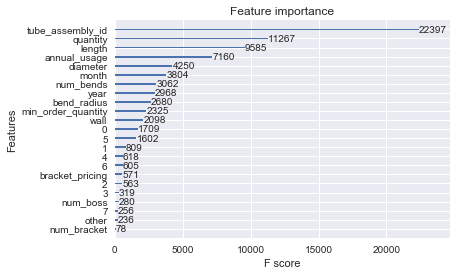

In [106]:
xgb.plot_importance(model)

In [107]:
pred_y_xgb = np.expm1(pred_y_xgb)
pred_y_xgb = pd.DataFrame(pred_y_xgb)
submit_xgb = pd.concat([test_id, pred_y_xgb], axis = 1)
submit_xgb.columns = ['id', 'cost']

In [108]:
submit_xgb.to_csv('benchmark_xgb.csv', index=False)

제출 결과: (Public score) 0.329346, (Private score) 0.325552. RF 보다 낫지만 역시 미흡 (총 1325명 중 900등 수준)

In [20]:
temp = pd.concat([fin_train_df, log_df_y], axis=1)

In [17]:
corr = temp.corr()

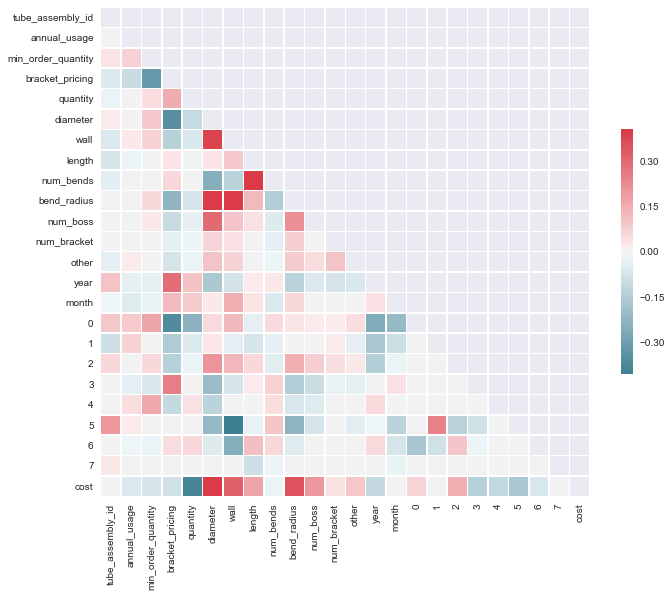

In [18]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})